## Import Packages

In [1]:
import cv2
import os
import math
import collections
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Global Variables

In [2]:
test_images_path = 'test_images/'
test_images_extra = 'test_images_extra/'

## Helper Functions

In [3]:
def read_image(image_path):
    """This function reads in an image an prints out some stats
    """
    input_image = mpimg.imread(image_path)
    return input_image

In [4]:
def grayscale(img):
    """Applies the Grayscale transform)"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [5]:
def hlsscale(img):
    """Applies the HLS transform)"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

In [6]:
def create_if_not_existing(path):
    if not os.path.isdir(path):
        os.mkdir(path)
    return

In [7]:
def save_image(image, image_name, debug_path, cmap=None, prefix='debug-'):
    create_if_not_existing(debug_path)
    plt.imshow(image, cmap=cmap)
    plt.title(prefix)
    plt.imsave(debug_path + prefix + image_name, image, cmap=cmap)
    plt.show()

## Classes - Wrappers for different functionalities

In [8]:
class Camera:
    
    # Create placeholders for various parameters
    
    # Arrays to store object points and image points from all the images
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane
    
     # Variables that store calibrated parameters of the camera
    camera_matrix = None
    distortion_coeff = None
    
    # Variable that holds the shape of the image as width and height
    image_size = None
    
    
    def __init__(self, debug=False, pattern_size=(9,6), \
                 calib_input_path="camera_cal/", calib_debug_path="camera_cal_debug/"):
        # Is debug info required?
        self.debug = debug
        
        # This holds the number of inside corners in X and Y direction as a tuple
        self.pattern_size = pattern_size
        
        # The path for input calibration images
        self.calib_input_path = calib_input_path
        
        # The path for debugging images
        self.calib_debug_path = calib_debug_path
        
        # The variable that stores the object points for the given pattern size
        self.objp = self.__prepare_object_points(pattern_size)
        
        # Calibrate the camera once
        self.camera_matrix, self.distortion_coeff = self.__calibrate_camera()
    
    
    def __prepare_object_points(self, pattern_size):
        # Prepare object points like (0,0,0), (1,0,0), (2,0,0)....,(8,5,0)
        num_x = self.pattern_size[0]  # Number of inside corners in X direction
        num_y = self.pattern_size[1]  # Number of inside corners in Y direction

        objp = np.zeros((num_x*num_y, 3), np.float32)
        objp[:,:2] = np.mgrid[0:num_x, 0:num_y].T.reshape(-1,2)
        return objp
    
    
    def __find_corners(self, image, pattern_size):
        # Find the corners in the chessboard image
        ret , corners = cv2.findChessboardCorners(grayscale(image), pattern_size)
        return ret, corners
    
    
    def __display_debug_info(self, image, image_name, pattern_size, corners, ret):
        cv2.drawChessboardCorners(image, pattern_size, corners, ret)
        save_image(image, image_name, self.calib_debug_path)
    
    
    def __collect_points(self):
        for image_name in os.listdir(self.calib_input_path):
            image = read_image(self.calib_input_path + image_name)
            self.image_size = image.shape[1::-1]
            ret, corners = self.__find_corners(image, self.pattern_size)
            if ret == True:
                self.imgpoints.append(corners)
                self.objpoints.append(self.objp)
                if self.debug == True:
                    self.__display_debug_info(image, image_name, self.pattern_size, corners, ret)
    
    
    def __calibrate_camera(self):
        self.__collect_points()
        ret, self.camera_matrix, self.distortion_coeff , rvecs, tvecs = \
                cv2.calibrateCamera(self.objpoints, self.imgpoints, self.image_size, None, None)
        return self.camera_matrix, self.distortion_coeff
    
    
    def undistort_image(self, image):
        undistorted_image = cv2.undistort(image, self.camera_matrix, self.distortion_coeff)
        if self.debug==True:
            save_image(undistorted_image, image_name, 'test_images_undistorted/')
        return undistorted_image

In [9]:
class ColorFilter:
    
    def __init__(self, debug=False):
        # Is debug info required?
        self.debug = debug
        
        # Variables to store converted images
        self.hls = None
        self.rgb = None
    
    def __initialise_image_parameters(self, image):
        # Convert the given image to hls scale
        self.hls = hlsscale(image)
        
        # Copy the given image in a variable
        self.rgb = image
    
    def __r_channel_thresh(self, thresh=(0, 255)):
        # Extract the H channel
        R = self.rgb[:,:,0]

        # Apply threshold
        r_binary_output = np.zeros_like(R)
        r_binary_output[(R > thresh[0]) & (R <= thresh[1])] = 1

        return r_binary_output
    
    
    def __h_channel_thresh(self, thresh=(0, 255)):
        # Extract the H channel
        H = self.hls[:,:,0]

        # Apply threshold
        h_binary_output = np.zeros_like(H)
        h_binary_output[(H > thresh[0]) & (H <= thresh[1])] = 1

        return h_binary_output
 
    def __l_channel_thresh(self, thresh=(0, 255)):
        # Extract the L channel
        L = self.hls[:,:,1]

        # Apply threshold
        l_binary_output = np.zeros_like(L)
        l_binary_output[(L > thresh[0]) & (L <= thresh[1])] = 1

        return l_binary_output
    
    def __s_channel_thresh(self, thresh=(0, 255)):
        # Extract the S channel
        S = self.hls[:,:,2]

        # Apply threshold
        s_binary_output = np.zeros_like(S)
        s_binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1

        return s_binary_output


    def apply_color_thresholds(self, image, r_thresh=(0,255), h_thresh=(0,255), l_thresh=(0,255), s_thresh=(0,255)):
        # Initialise the image parameters
        self.__initialise_image_parameters(image)        
        
        # Apply each of the thresholding functions
        r_binary = self.__r_channel_thresh(thresh=r_thresh)
        h_binary = self.__h_channel_thresh(thresh=h_thresh)
        l_binary = self.__l_channel_thresh(thresh=l_thresh)
        s_binary = self.__s_channel_thresh(thresh=s_thresh)
         
        # Create a combined image from individual binaries    
        # From experimentation with the test images, only the R channel and S channel gives resonable output.
        combined = np.zeros_like(s_binary)
        combined[(r_binary == 1) | (s_binary == 1)] = 1
        
        if self.debug == True:
            save_image(r_binary, image_name, 'test_images_thresholded/', 'gray', 'rchannel-')
            save_image(h_binary, image_name, 'test_images_thresholded/', 'gray', 'hchannel-')
            save_image(l_binary, image_name, 'test_images_thresholded/', 'gray', 'lchannel-')
            save_image(s_binary, image_name, 'test_images_thresholded/', 'gray', 'schannel-')
            save_image(combined, image_name, 'test_images_thresholded/', 'gray', 'color-combined-')
        
        return combined

In [10]:
class GradientFilter:
    
    def __init__(self, ksize=3, debug=False):
        # Is debug info required?
        self.debug = debug
                
        # Choose a Sobel kernel size        
        self.ksize = ksize # Choose a larger odd number to smooth gradient measurements
        
        # Variable to store the converted image
        self.gray = None
        
        # Gradient along the X direction
        self.sobel_x = None
        
        # Gradient along the Y direction
        self.sobel_y = None
        
        # Magnitude or absolute value of the derivative along X direction
        self.abs_sobel_x = None
        
        # Magnitude or absolute value of the derivative along Y direction
        self.abs_sobel_y = None
        
        # Magnitude or absolute value of the derivative along both X and Y directions
        self.abs_sobel_xy =  None
        
    def __initialise_image_parameters(self, image):
        
        # Convert the given image to grayscale
        self.gray = grayscale(image)
        
        # Gradient along the X direction
        self.sobel_x = cv2.Sobel(self.gray, cv2.CV_64F, 1, 0, ksize=self.ksize)
        
        # Gradient along the Y direction
        self.sobel_y = cv2.Sobel(self.gray, cv2.CV_64F, 0, 1, ksize=self.ksize)
        
        # Magnitude or absolute value of the derivative along X direction
        self.abs_sobel_x = np.absolute(self.sobel_x)
        
        # Magnitude or absolute value of the derivative along Y direction
        self.abs_sobel_y = np.absolute(self.sobel_y)
        
        # Magnitude or absolute value of the derivative along both X and Y directions
        self.abs_sobel_xy =  np.sqrt( (self.sobel_x)**2 + (self.sobel_y)**2 )
    
    def __abs_sobel_thresh(self, orient='x', thresh=(0, 255)):
        # Calculate directional gradient
        if orient == 'x':
            abs_sobel = self.abs_sobel_x
        else:
            abs_sobel = self.abs_sobel_y
 
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        # Apply threshold
        grad_binary = np.zeros_like(scaled_sobel)
        grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
        return grad_binary

    def __mag_thresh(self, thresh=(0, 255)):
        # Calculate gradient magnitude
        scaled_sobel = np.uint8(255*self.abs_sobel_xy/np.max(self.abs_sobel_xy))
        # Apply threshold
        mag_binary = np.zeros_like(scaled_sobel)
        mag_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
        return mag_binary

    def __dir_threshold(self, thresh=(0, np.pi/2)):
        # Calculate gradient direction
        direction = np.arctan2(self.abs_sobel_y, self.abs_sobel_x)
        # Apply threshold
        dir_binary = np.zeros_like(direction)
        dir_binary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
        return dir_binary

    def apply_gradient_thresholds(self, image, abs_thresh_x=(0,255), abs_thresh_y=(0,255), mag_thresh=(0,255), dir_thresh=(0, np.pi/2)):
        # Initialise the image parameters
        self.__initialise_image_parameters(image)
        
        # Apply each of the thresholding functions
        gradx_binary = self.__abs_sobel_thresh(orient='x', thresh= abs_thresh_x)
        grady_binary = self.__abs_sobel_thresh(orient='y', thresh=abs_thresh_y)
        mag_binary = self.__mag_thresh(thresh=mag_thresh)
        dir_binary = self.__dir_threshold(thresh=dir_thresh)

        # Create a combined image from individual binaries
        combined = np.zeros_like(dir_binary)
        combined[((gradx_binary == 1) & (grady_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
        
        if self.debug == True:
            save_image(gradx_binary, image_name, 'test_images_thresholded/', 'gray', 'gradx-')
            save_image(grady_binary, image_name, 'test_images_thresholded/', 'gray', 'grady-')
            save_image(mag_binary, image_name, 'test_images_thresholded/', 'gray', 'mag-')
            save_image(dir_binary, image_name, 'test_images_thresholded/', 'gray', 'dir-')
            save_image(combined, image_name, 'test_images_thresholded/', 'gray', 'gradient-combined-')
        
        return combined

In [11]:
class PerpectiveTransformer:
    
    def __init__(self, image, debug=False):
        # Store the image in member variable
        self.image = image
        
        # Is debug info required?
        self.debug = debug
        
        self.__initialise_image_parameters(image)
   
    def __initialise_image_parameters(self, image):
        
        # Store the width and height of the image as separate member variables
        self.width = image.shape[1]
        self.height = image.shape[0]
        
        # The points are the in the order top-left, bottem-left, bottom-right, top-right
        
        # The region of interest represented as vertices
        self.src = np.float32([ [math.ceil(self.width*0.423) , math.ceil(0.652*self.height)], [math.ceil(self.width*0.08), self.height],  \
                          [math.ceil(self.width*0.921), self.height],  [math.ceil(0.578*self.width) , math.ceil(0.652*self.height)] ])
        
        self.dst = np.float32([ [math.ceil(self.width*0.156), 0], [math.ceil(self.width*0.156), self.height], \
                               [math.ceil(self.width*0.843), self.height],  [math.ceil(self.width*0.843) , 0] ])
        
        self.transform_matrix  = cv2.getPerspectiveTransform(self.src, self.dst)
        self.inverse_transform_matrix = cv2.getPerspectiveTransform(self.dst, self.src)

    def apply_perpective_transform(self, input_image):        
        warped_image = cv2.warpPerspective(input_image, self.transform_matrix, (self.width, self.height), flags=cv2.INTER_LINEAR)
        if self.debug == True:
            save_image(warped_image, image_name, 'test_images_warped/', cmap='gray', prefix='warped-')
        return warped_image
    
    def remove_perspective_transform(self, input_image):
        unwarped_image = cv2.warpPerspective(input_image, self.inverse_transform_matrix, (self.width, self.height), flags=cv2.INTER_LINEAR)
        if self.debug == True:
            save_image(unwarped_image, image_name, 'test_images_warped/', cmap='gray', prefix='unwarped-')
        return unwarped_image
        

In [12]:
class LaneFinder():
    
    def __init__(self, nwindows=9, margin=100, minpix=50, m_lane_width=3.7, m_lane_length= 23, left_fit=None, right_fit= None, debug=False):
        # Is debug info required?
        self.debug = debug
        
        # Member variable that defines whether the fit polynomials are available
        self.polyfit_available = False
        
        # HYPERPARAMETERS
        # Choose the number of sliding windows
        self.nwindows = nwindows
        # Set the width of the windows +/- self.margin
        self.margin = margin
        # Set minimum number of pixels found to recenter window
        self.minpix = minpix
        
        # Define conversions in x and y from pixels space to meters        
        # Based on the perspective transformation the following parameters are defined
        self.ym_per_pix = m_lane_length/720 # meters per pixel in y dimension
        self.xm_per_pix = m_lane_width/735 # meters per pixel in x dimension
    
    def __initialise_image_parameters(self, image, left_fit, right_fit):
        if isinstance(left_fit, np.ndarray) and isinstance(right_fit, np.ndarray):
            # Initialise member variable that the fit polynomials are available
            self.polyfit_available = True
        
        # Store the image in a member variable
        self.image = image
        
        # Create an output image to draw on and visualize the result
        self.out_image = np.dstack((self.image, self.image, self.image))
        
        # Take a histogram of the bottom half of the image
        self.histogram = np.sum(self.image[self.image.shape[0]//2:,:], axis=0)
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        self.midpoint = np.int(self.histogram.shape[0]//2)
        self.leftx_base = np.argmax(self.histogram[:self.midpoint])
        self.rightx_base = np.argmax(self.histogram[self.midpoint:]) + self.midpoint
         
        # Set height of windows - based on self.nwindows above and image shape
        self.window_height = np.int(self.image.shape[0]//self.nwindows)
        
        # Identify the x and y positions of all nonzero pixels in the image
        self.nonzero = self.image.nonzero()
        self.nonzeroy = np.array(self.nonzero[0])
        self.nonzerox = np.array(self.nonzero[1])
        
        # Variables to store lane fit polynomials
        self.left_fit = left_fit
        self.right_fit = right_fit
        
       
        # Define y-value where we want radius of curvature
        # We'll choose the maximum y-value, corresponding to the bottom of the image
        self.y_eval = self.image.shape[0]-1
        
        # Variables for R_curve (radius of curvature)
        self.left_curve_radius = None
        self.right_curve_radius = None
        
        # Variables for offset ( the offset between center of car and center of lane)
        self.offset = None
    
    def __window_slider_algorithm(self, leftx_current, rightx_current):
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        
        # Step through the windows one by one
        for window in range(self.nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = self.image.shape[0] - (window+1)*self.window_height
            win_y_high = self.image.shape[0] - window*self.window_height
            win_xleft_low = leftx_current - self.margin
            win_xleft_high = leftx_current + self.margin
            win_xright_low = rightx_current - self.margin
            win_xright_high = rightx_current + self.margin

            # Draw the windows on the visualization image
            cv2.rectangle(self.out_image, (win_xleft_low, win_y_low), \
                          (win_xleft_high, win_y_high), (0,255,0), 5)
            cv2.rectangle(self.out_image, (win_xright_low, win_y_low),\
                          (win_xright_high, win_y_high), (0,255,0), 5) 

            # Identify the nonzero pixels in x and y within the window #
            good_left_inds = ((self.nonzeroy >= win_y_low) & (self.nonzeroy < win_y_high) & \
                              (self.nonzerox >= win_xleft_low) &  (self.nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((self.nonzeroy >= win_y_low) & (self.nonzeroy < win_y_high) & \
                                (self.nonzerox >= win_xright_low) &  (self.nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > self.minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > self.minpix:
                leftx_current = np.int(np.mean(self.nonzerox[good_left_inds]))
            if len(good_right_inds) > self.minpix:        
                rightx_current = np.int(np.mean(self.nonzerox[good_right_inds]))
    
        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            # Throw an error if the above is not fuctioning
            print('Error in concatenation')
            pass
        
        return left_lane_inds, right_lane_inds
    
    def __search_around_polynomial_algorithm(self):
        left_lane_inds = ((self.nonzerox > (self.left_fit[0]*(self.nonzeroy**2) + self.left_fit[1]*self.nonzeroy + 
                    self.left_fit[2] - self.margin)) & (self.nonzerox < (self.left_fit[0]*(self.nonzeroy**2) + 
                    self.left_fit[1]*self.nonzeroy + self.left_fit[2] + self.margin)))
        right_lane_inds = ((self.nonzerox > (self.right_fit[0]*(self.nonzeroy**2) + self.right_fit[1]*self.nonzeroy + 
                    self.right_fit[2] - self.margin)) & (self.nonzerox < (self.right_fit[0]*(self.nonzeroy**2) + 
                    self.right_fit[1]*self.nonzeroy + self.right_fit[2] + self.margin)))
        
        return left_lane_inds, right_lane_inds
    
    
    def __find_lane_pixels(self):        
        # Current positions to be updated later for each window in nwindows
        leftx_current = self.leftx_base
        rightx_current = self.rightx_base
        
        if self.polyfit_available == True:
            left_lane_inds, right_lane_inds = self.__search_around_polynomial_algorithm()
        
        if self.polyfit_available == False:
            left_lane_inds, right_lane_inds = self.__window_slider_algorithm(leftx_current, rightx_current)

        # Extract left and right line pixel positions
        leftx = self.nonzerox[left_lane_inds]
        lefty = self.nonzeroy[left_lane_inds] 
        rightx = self.nonzerox[right_lane_inds]
        righty = self.nonzeroy[right_lane_inds]

        return leftx, lefty, rightx, righty
    
    def __visualise_poly_region(self, leftx, lefty, rightx, righty, left_fitx, right_fitx, ploty ):
        ## Visualization ##
        # Create an image to draw on and an image to show the selection window
        #self.out_image = np.dstack((self.image, self.image, self.image))*255
        window_img = np.zeros_like(self.out_image)
        # Color in left and right line pixels
        self.out_image[lefty, leftx] = [255, 0, 0]
        self.out_image[righty, rightx] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-self.margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+self.margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-self.margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+self.margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        self.out_image = cv2.addWeighted(self.out_image, 1, window_img, 0.3, 0)


        
    def __visualise_lane_lines(self, leftx, lefty, rightx, righty):
        # Generate x and y values for plotting
        ploty = np.linspace(0, self.image.shape[0]-1, self.image.shape[0] )
        try:
            left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
            right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            left_fitx = 1*ploty**2 + 1*ploty
            right_fitx = 1*ploty**2 + 1*ploty
        
        # Colors in the left and right lane regions
        self.out_image[lefty, leftx] = [255, 0, 0]
        self.out_image[righty, rightx] = [0, 0, 255]
        
        if self.polyfit_available == True:
            self.__visualise_poly_region(leftx, lefty, rightx, righty, left_fitx, right_fitx, ploty)
            
        # Plots the left and right polynomials on the lane lines
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.imshow(self.out_image)
        plt.savefig('test_images_lanelines_window/windowslider-straight_lines1.jpg', dpi=1000)
        plt.show()
        
        #save_image(self.out_image, image_name, 'test_images_lanelines_window/', prefix='windowslider-')
        
    
    def get_lane_polynomials(self, image=None, left_fit=None, right_fit=None):

        # Initialse the various parametes of the image
        self.__initialise_image_parameters(image, left_fit, right_fit)
        
        # Find our lane pixels first
        leftx, lefty, rightx, righty = self.__find_lane_pixels()

        # Fit a second order polynomial to each using `np.polyfit`
        self.left_fit = np.polyfit(lefty, leftx, 2)
        self.right_fit = np.polyfit(righty, rightx, 2)
        
        # Prepare other necessary data like the color filled warped image,
        # radius of curvature and offset from center values
        self.__calculate_offset()
        self.__calculate_lane_curvature()
        
        if self.debug == True:
            self.__visualise_lane_lines(leftx, lefty, rightx, righty)
        
        return self.left_fit, self.right_fit
    
    def __calculate_offset(self):
        # Camera line -- y value where the camera exists is self.y_eval
        
        # find the x points where the left lane and right lane meets the camera line
        left_fit_x_eval = self.left_fit[0]*self.y_eval**2 + self.left_fit[1]*self.y_eval + self.left_fit[2]
        right_fit_x_eval = self.right_fit[0]*self.y_eval**2 + self.right_fit[1]*self.y_eval + self.right_fit[2]
        
        # Calculate the offset between center of vehicle and center of lane
        lane_width = right_fit_x_eval - left_fit_x_eval
        center_lane = left_fit_x_eval + (lane_width/2)
        center_vehicle = self.image.shape[1]//2
        self.offset = (center_lane - center_vehicle) * self.xm_per_pix
        
        return 
        
    def get_offset(self):
        # Determine whether the vehicle is left or right of the lane center    
        if self.offset > 0:
            side = 'left'
        else:
            side = 'right'
   
        return self.offset, side 
    
    def get_filled_lanes(self):
        return self.color_filled_warped
    
    def get_lane_curvature(self):
        return self.left_curve_radius/1000, self.right_curve_radius/1000
    
    def __calculate_lane_curvature(self):
        left_fit_scaled = np.array([ (self.xm_per_pix / (self.ym_per_pix ** 2) ) * self.left_fit[0] , \
                            (self.xm_per_pix/self.ym_per_pix) * self.left_fit[1], self.left_fit[0] ])
        right_fit_scaled = np.array([ (self.xm_per_pix / (self.ym_per_pix ** 2) ) * self.right_fit[0] , \
                            (self.xm_per_pix/self.ym_per_pix) * self.right_fit[1], self.right_fit[0] ])        
    
        # Calculation of R_curve (radius of curvature)
        self.left_curve_radius = ((1 + (2*left_fit_scaled[0]*self.y_eval + \
                                   left_fit_scaled[1])**2)**1.5) / np.absolute(2*left_fit_scaled[0])
        self.right_curve_radius = ((1 + (2*right_fit_scaled[0]*self.y_eval + \
                                    right_fit_scaled[1])**2)**1.5) / np.absolute(2*right_fit_scaled[0])
    
        
        return self.left_curve_radius/1000, self.right_curve_radius/1000



In [13]:
class LaneHistory():
    def __init__(self, buffer_length):
        # number of frames that fails sanity check
        self.dropped = 0 # O means the detection was successfull in the last frame
        #polynomial coefficients over the last n iterations
        self.polyfit_buffer = collections.deque(maxlen=buffer_length)
        #polynomial coefficients for the most recent fit
        self.latest_polyfit = None  
        #radius of curvature of the latest polynomial in some units
        self.latest_radius_of_curvature = None 
        #offset value of the latest frame
        self.latest_offset = None
        #lane width of the latest polynomial fit (should be same on both lanes)
        self.latest_lane_width = None
        
    def update_history(self, detected, fit, curve_radius, offset):
        # Update the drop counter
        if detected == True:
            self.dropped = 0
        else:
            self.dropped = self.dropped + 1
        
        # Update the latest polyfit
        self.latest_polyfit = fit
        
        # Update the latest offset
        self.latest_offset = offset
        
        # Update the latest radius of curvature
        self.latest_radius_of_curvature = curve_radius
        
        # Append the polyfit to the buffer
        self.polyfit_buffer.append(fit)

    
    def is_history_available(self):
        # Returns whether there is a history available
        if len(self.polyfit_buffer) > 0:
            return True
        else:
            return False

    def get_average_fit(self):
        # Weights that gives more importance to the lastest fit
        linear_weights = np.linspace(1, len(self.polyfit_buffer), len(self.polyfit_buffer))
        exp_weights = np.exp(linear_weights)
        weights = linear_weights
        average = np.average(self.polyfit_buffer, 0, weights)
        return average
    
    def update_drop_counter(self):
        self.dropped = self.dropped + 1
   

## Sanity Check Function

In [14]:
def sanity_check(image, left_fit, right_fit, left_curve_radius, right_curve_radius, m_lane_width=3.7, m_lane_length= 23):
    # Check 1: Checking that the past and current lines have similar curvatures
    radius_thresh = 0.5
    if left_history.is_history_available() and right_history.is_history_available():
        radius_check = (np.absolute(left_curve_radius - left_history.latest_radius_of_curvature) <= radius_thresh) & \
                        (np.absolute(right_curve_radius - right_history.latest_radius_of_curvature) <= radius_thresh)
    else:
        radius_check = True
    
    # Check 2: Checking that the lanes are separated by appx. same distance horizontally
    
    y_sample_points = np.linspace(0, image.shape[0]-1, 10)

    # find the x points where the left lane and right lane meets the camera line
    left_fit_x_eval = left_fit[0]*y_sample_points**2 + left_fit[1]*y_sample_points + left_fit[2]
    right_fit_x_eval = right_fit[0]*y_sample_points**2 + right_fit[1]*y_sample_points + right_fit[2]
    
    # Define conversions in x and y from pixels space to meters
    # Based on the perspective transformation the following parameters are defined
    ym_per_pix = m_lane_length/720 # meters per pixel in y dimension
    xm_per_pix = m_lane_width/735 # meters per pixel in x dimension
    
    # Find the width of the lane along the sample points
    lane_width_sample_points = (right_fit_x_eval - left_fit_x_eval)*xm_per_pix
    
    # Check whether the lane width within the allowed range (3 m to 4.5 m)
    legal_width_check = np.alltrue(lane_width_sample_points >= 3) and np.alltrue(lane_width_sample_points <= 4.5)
             
    # Check with history whether the change is within a threshold
    if left_history.is_history_available() and right_history.is_history_available():
        history_width_check = np.absolute(left_history.latest_lane_width - (np.average(lane_width_sample_points))) < 0.75
    else:
        history_width_check = True
    
    
    # Check 3: Checking that the lanes are roughly parallel
    parallel_check = np.max(lane_width_sample_points) - np.min(lane_width_sample_points) < 1
    

    
    result = radius_check or legal_width_check and history_width_check and parallel_check
    
    
    if result == True or left_history.is_history_available() == False or right_history.is_history_available()==False:
        #Add the current average value of lane width to history. Always update for first frames
        left_history.latest_lane_width = np.average(lane_width_sample_points)
        right_history.latest_lane_width = np.average(lane_width_sample_points)
    
    '''
    print(radius_check)
    print(legal_width_check)
    print(history_width_check)
    print(parallel_check)
    '''

    return result


## Function that creates the output image 

In [15]:
def get_output_image(transformer, undistorted_image, warped_image, polyfit, radius, offset, debug=False):
    
    #Parse the arguments
    left_fit = polyfit[0]
    right_fit = polyfit[1]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_filled_warped = np.dstack((warp_zero, warp_zero, warp_zero))

    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_filled_warped, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)   
    unwarped_image = transformer.remove_perspective_transform(color_filled_warped)
   
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_image, 1, unwarped_image, 0.3, 0)
    
    
    cv2.putText(result, 'Radius of Curvature = {:.3f}'.format(radius) +'(km)', \
                (100,100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(result, 'Vehicle is {:.3f}'.format(np.absolute(offset[0])) +'m '+ offset[1] +' of center', \
                (100,170), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)

    return result

## Lane Finding Pipeline

In [16]:
def advanced_lane_finding_pipeline(input_image, debug=False):
    
    #Step 1: Apply a distortion correction to raw images.
    
    undistorted_image = camera.undistort_image(input_image)

    # Step 2: Use color transforms to create a thresholded binary image.
    
    color_filtered_image = color.apply_color_thresholds(undistorted_image, \
                                    r_thresh=(225,255), h_thresh=(100,255), l_thresh=(150,255), s_thresh=(110,255))
    # Step 3: Use gradients to create a thresholded binary image.
    
    gradient_filtered_image = gradient.apply_gradient_thresholds(undistorted_image, \
                                    abs_thresh_x=(20, 150), abs_thresh_y=(40, 180), mag_thresh=(40, 150), dir_thresh=(0.8, 1.3))
         
    ''' 
    # Alternative parameters that could be useful
    gradient_filtered_image = gradient.apply_gradient_thresholds(undistorted_image, \
                                    abs_thresh_x=(20, 100), abs_thresh_y=(40, 100), mag_thresh=(40, 100), dir_thresh=(0.8, 1.3))
    
    color = ColorFilter(debug=True)
    color_filtered_image = color.apply_color_thresholds(undistorted_image, \
                                    r_thresh=(225,255), h_thresh=(100,255), l_thresh=(150,255), s_thresh=(110,255))
    '''
    
    # Step 4: Create a thresholded binary image from both color and gradient filtered binary images.
    
    filters_combined = np.zeros_like(gradient_filtered_image, np.uint8)
    filters_combined[(gradient_filtered_image == 1) | (color_filtered_image == 1)] = 255
    
    if debug==True:
        save_image(filters_combined, image_name, 'test_images_thresholded/', 'gray', 'filters-combined-')

    # Step 5: Apply a perspective transform to rectify binary image ("birds-eye view").
    
    # An object for PerspectiveTransformer is created here since images of different sizes can cause the pipeline to fail    
    transformer = PerpectiveTransformer(input_image, debug=False)
    warped_image = transformer.apply_perpective_transform(filters_combined)
    
    # Step 6: Detect lane pixels and fit to find the lane boundary.
    
    
    
    # The pipeline will tolerate continous failures for two times and then it will switch to window slider algorithm   
    if left_history.dropped <= 1 and right_history.dropped <= 1 \
            and left_history.is_history_available() == True and right_history.is_history_available()==False:
        # Get the lane polynomial using look ahead algorithm         
        left_fit, right_fit = \
                finder.get_lane_polynomials(warped_image, left_history.current_fit, right_history.current_fit)
    else:        
        # Get the lane polynomial using window slider algorithm  
        left_fit, right_fit = finder.get_lane_polynomials(warped_image)
    
    
    # Step 7: Determine the curvature of the lane and vehicle position with respect to center.
    
    left_curve_radius, right_curve_radius = finder.get_lane_curvature()
    avg_radius = (left_curve_radius + right_curve_radius)/2
    offset_value, offset_side = finder.get_offset()
    
    
    # Step 8: Perform a sanity check on the intermediate results
    check = sanity_check(input_image, left_fit, right_fit, left_curve_radius, right_curve_radius)
    
    if check == True or left_history.is_history_available() == False or right_history.is_history_available()==False \
                or left_history.dropped >=2 or right_history.dropped >=2:
        # For first frame always update history
        left_history.update_history(True, left_fit, left_curve_radius, (offset_value, offset_side))
        right_history.update_history(True, right_fit, right_curve_radius, (offset_value, offset_side))
        # Sometimes bad curvature radius is displayed because of mandatory update after two consecutive failures
    else:
        # For first frame always update history
        global drop_counter
        drop_counter = drop_counter + 1
        left_history.update_drop_counter()
        right_history.update_drop_counter()
        # Scrap the available found values and use the data from history
        avg_radius = (left_history.latest_radius_of_curvature + right_history.latest_radius_of_curvature)/2
        offset_value, offset_side = left_history.latest_offset[0], left_history.latest_offset[1]

        
    # Always take the average value of polynomial fit to smoothen the output image
    avg_left_fit = left_history.get_average_fit()
    avg_right_fit = right_history.get_average_fit()
    
    
    # Step 9: Warp the detected lane boundaries back onto the original image and visual display of the outputs
    output_image = get_output_image(transformer, undistorted_image, warped_image, \
                                    (avg_left_fit, avg_right_fit), avg_radius, (offset_value, offset_side),  debug)
    

    
    if debug==True:
        save_image(output_image, image_name, 'output_images/', prefix='output-')

    return output_image


## Test on images

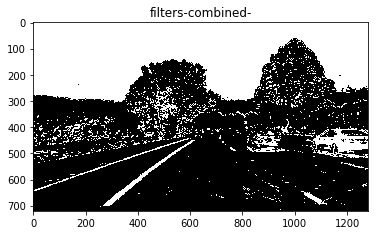

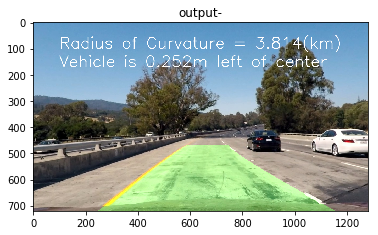

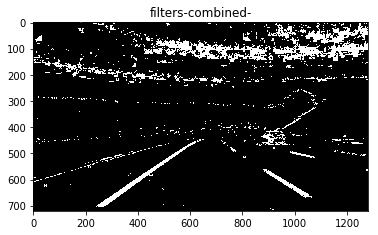

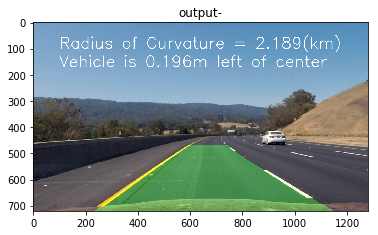

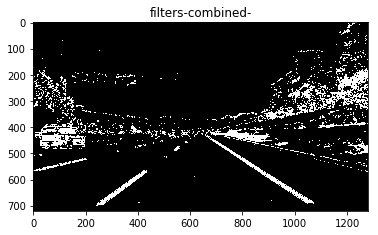

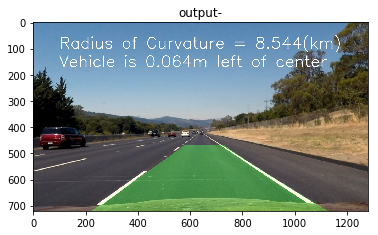

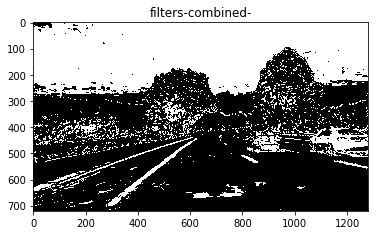

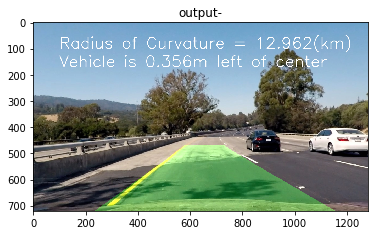

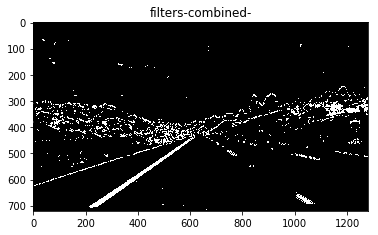

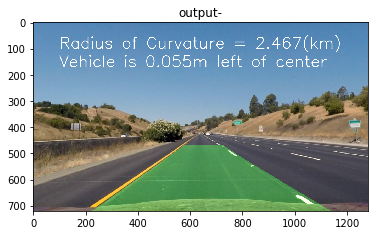

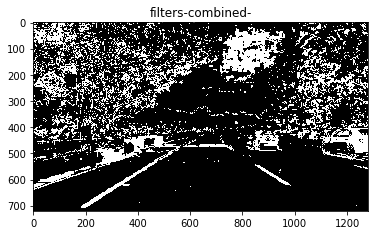

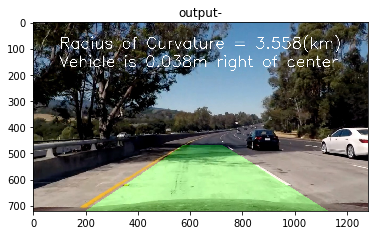

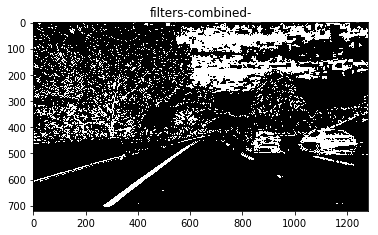

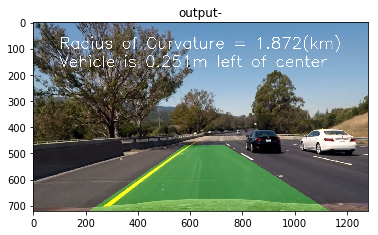

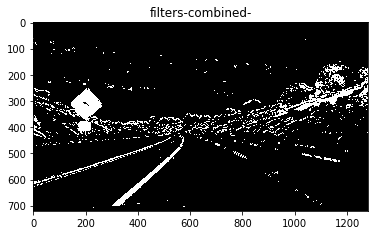

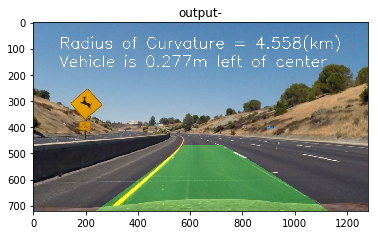

In [17]:
# Create commom objects 
camera = Camera(debug=False)
gradient = GradientFilter(ksize=11, debug=False)
color = ColorFilter(debug=False)
finder = LaneFinder(minpix=20, debug=False)

left_history = LaneHistory(buffer_length=5)
right_history = LaneHistory(buffer_length=5)

# Create an example for undistored image 
#dist_calib_image = read_image('./camera_cal/calibration1.jpg')
#undist_calib_image = camera.undistort_image(dist_calib_image)
#save_image(undist_calib_image, 'calibration1.jpg', 'writeup_images/', prefix='undistorted-calib')


# Initialise the test directory
test_input_dir = test_images_path

for image_name in os.listdir(test_input_dir): 
    input_image = read_image(test_input_dir + image_name)
    advanced_lane_finding_pipeline(input_image, debug=True)

## Test on Videos

In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [19]:
def process_image(image):
    result = advanced_lane_finding_pipeline(image)
    return result

In [20]:
# Create commom objects 
camera = Camera()
gradient = GradientFilter(ksize=11, debug=False)
color = ColorFilter(debug=False)
finder = LaneFinder(minpix=20, debug=False)

# Create objects for history for each individual video
left_history = LaneHistory(buffer_length=15)
right_history = LaneHistory(buffer_length=15)
drop_counter = 0

# Create a variable for output video
project_output = 'output_videos/project_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

print('Number of frames dropped because of sanity check: ' + str(drop_counter))

[MoviePy] >>>> Building video output_videos/project_output.mp4
[MoviePy] Writing video output_videos/project_output.mp4


100%|█████████▉| 1260/1261 [06:07<00:00,  3.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_output.mp4 

CPU times: user 3min 49s, sys: 12.8 s, total: 4min 2s
Wall time: 6min 10s
Number of frames dropped because of sanity check: 17


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

In [22]:
''' 
# Logic to generate test images from videos
counter = 0
def process_image(image):
    global counter
    save_image(image, str(counter), 'test_images_extra/', prefix='extra-challenge-')
    counter = counter + 1
    result = advanced_lane_finding_pipeline(image)
    return result


# Create objects for history for each individual video
left_history = LaneHistory(buffer_length=15)
right_history = LaneHistory(buffer_length=15)

time_stamp = np.array([1,2,3,5,7,15], np.float32)


for subclip_end in time_stamp:
    subclip_start = subclip_end - 0.0025
    
    # Create a variable for output video
    challenge_output = 'output_videos/challenge_output.mp4'
    ## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
    ## To do so add .subclip(start_second,end_second) to the end of the line below
    ## Where start_second and end_second are integer values representing the start and end of the subclip
    ## You may also uncomment the following line for a subclip of the first 5 seconds
    ##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
    clip1 = VideoFileClip("challenge_video.mp4").subclip(subclip_start, i)
    project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
    %time project_clip.write_videofile(challenge_output, audio=False)
    
'''

' \n# Logic to generate test images from videos\ncounter = 0\ndef process_image(image):\n    global counter\n    save_image(image, str(counter), \'test_images_extra/\', prefix=\'extra-challenge-\')\n    counter = counter + 1\n    result = advanced_lane_finding_pipeline(image)\n    return result\n\n\n# Create objects for history for each individual video\nleft_history = LaneHistory(buffer_length=15)\nright_history = LaneHistory(buffer_length=15)\n\ntime_stamp = np.array([1,2,3,5,7,15], np.float32)\n\n\nfor subclip_end in time_stamp:\n    subclip_start = subclip_end - 0.0025\n    \n    # Create a variable for output video\n    challenge_output = \'output_videos/challenge_output.mp4\'\n    ## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video\n    ## To do so add .subclip(start_second,end_second) to the end of the line below\n    ## Where start_second and end_second are integer values representing the start and end of the subclip\n    ## Yo